# Notebook initialization
- install
- import

In [ ]:
!pip install neptune


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.9/487.9 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.6 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67675 sha256=a36e1e38b2e4831659bb86b5fd9f95e2d661d34cb960b21caf5141c94828647a
  Stored in directory: /root/.cache/pip/wheels/b8/56/c6/3695a1daf18ee45607f1d352fca288d173bc3b1722228c6fb1
Successfully built bravado-core


In [ ]:
import sys
import os

import neptune
import numpy as np

import tensorflow as tf
from tensorflow import keras

import plotly.graph_objects as go

## Importare dataset da Kaggle

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
louisburtz_learned_pose_estimation_robot_on_the_moon_path = kagglehub.dataset_download('louisburtz/learned-pose-estimation-robot-on-the-moon')

print('Data source import complete.')


Using Colab cache for faster access to the 'learned-pose-estimation-robot-on-the-moon' dataset.
Data source import complete.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("louisburtz/learned-pose-estimation-robot-on-the-moon")

print("Path to dataset files:", path)

# Move the dataset into /content folder
!mv /root/.cache/kagglehub/datasets/louisburtz/learned-pose-estimation-robot-on-the-moon/versions/1/hopper_4500_tf_data_* /content
!mv /kaggle/input/learned-pose-estimation-robot-on-the-moon/hopper_4500_tf_data_* /content

Using Colab cache for faster access to the 'learned-pose-estimation-robot-on-the-moon' dataset.
Path to dataset files: /kaggle/input/learned-pose-estimation-robot-on-the-moon
mv: cannot stat '/root/.cache/kagglehub/datasets/louisburtz/learned-pose-estimation-robot-on-the-moon/versions/1/hopper_4500_tf_data_*': No such file or directory
mv: cannot remove '/kaggle/input/learned-pose-estimation-robot-on-the-moon/hopper_4500_tf_data_test/element_spec': Read-only file system
mv: cannot remove '/kaggle/input/learned-pose-estimation-robot-on-the-moon/hopper_4500_tf_data_test/10634499268157367452/00000000.shard/00000000.snapshot': Read-only file system
mv: cannot remove '/kaggle/input/learned-pose-estimation-robot-on-the-moon/hopper_4500_tf_data_test/snapshot.metadata': Read-only file system
mv: cannot remove '/kaggle/input/learned-pose-estimation-robot-on-the-moon/hopper_4500_tf_data_train/element_spec': Read-only file system
mv: cannot remove '/kaggle/input/learned-pose-estimation-robot-on-t

## Download git repo

In [ ]:
!git clone https://github.com/TeamL3/learned-pose-estimation.git

Cloning into 'learned-pose-estimation'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 158 (delta 68), reused 126 (delta 38), pack-reused 0 (from 0)
Receiving objects: 100% (158/158), 31.15 MiB | 39.52 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
# connect all the folder and subfolders of git repo
base_path = "learned-pose-estimation"

for root, dirs, files in os.walk(base_path):
    if root not in sys.path:
        sys.path.insert(0, root)

import ml_utils
import pose_utils
from pose_utils import DEG_TO_RAD
from pose_utils import RAD_TO_SCALED
from pose_utils import MAX_DEPTH
from pose_utils import METERS_TO_SCALED
from pose_utils import INTENSITY_TO_SCALED

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.


# Data processing and Dataset Visualization

## Chose the dataset

In [ ]:
tf_data_path = '/content/hopper_4500_tf_data'

ds_split = 'train'
# ds_split = 'val'
# ds_split = 'test'

# each dataset shows images of a different target object:
target = pose_utils.which_target(tf_data_path + '_' + ds_split)
target


'processing_plant'

In [ ]:
# load dataset into ds
# This in a tensorflow dataset

ds = ml_utils.load_dataset(tf_data_path + '_' + ds_split, compression='GZIP')
# Prendi 1 elemento ogni 5
ds_reduced = ds.shard(num_shards=15, index=0)
ds = ds_reduced

# Plot the size of the dataset
size = tf.data.experimental.cardinality(ds).numpy()
print("Numero di elementi:", size)


Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


Numero di elementi: 195


image: tensore 480×640×4 (immagini 480x640 RGBD)

label: tensore di dimensione 3 (dist, theta, yaw)

In [ ]:
print(ds.element_spec)

(TensorSpec(shape=(480, 640, 4), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))


## Note about dataset
#### labels
- Distance: distanced from target
- Theta: angle of object w.r.t. camera
- Yaw: orientation of the rover w.r.t. world.

Note:
- yaw + pi/2 is the orientation of the camera w.r.t. the world

- Absolute_yaw = theta + yaw + pi/2: orientatio of the object w.r.t. world


img shape: (480, 640, 4), found 4 channels
raw:   d = 0.259 , theta = 0.079    , yaw = 0.046 
human: d = 6.48 m, theta = 14.2 deg, yaw = 8.3 deg
img shape: (480, 640, 4), found 4 channels
raw:   d = 0.393 , theta = -0.246    , yaw = 0.051 
human: d = 9.82 m, theta = -44.2 deg, yaw = 9.2 deg
img shape: (480, 640, 4), found 4 channels
raw:   d = 0.198 , theta = -0.422    , yaw = 0.095 
human: d = 4.94 m, theta = -76.0 deg, yaw = 17.1 deg


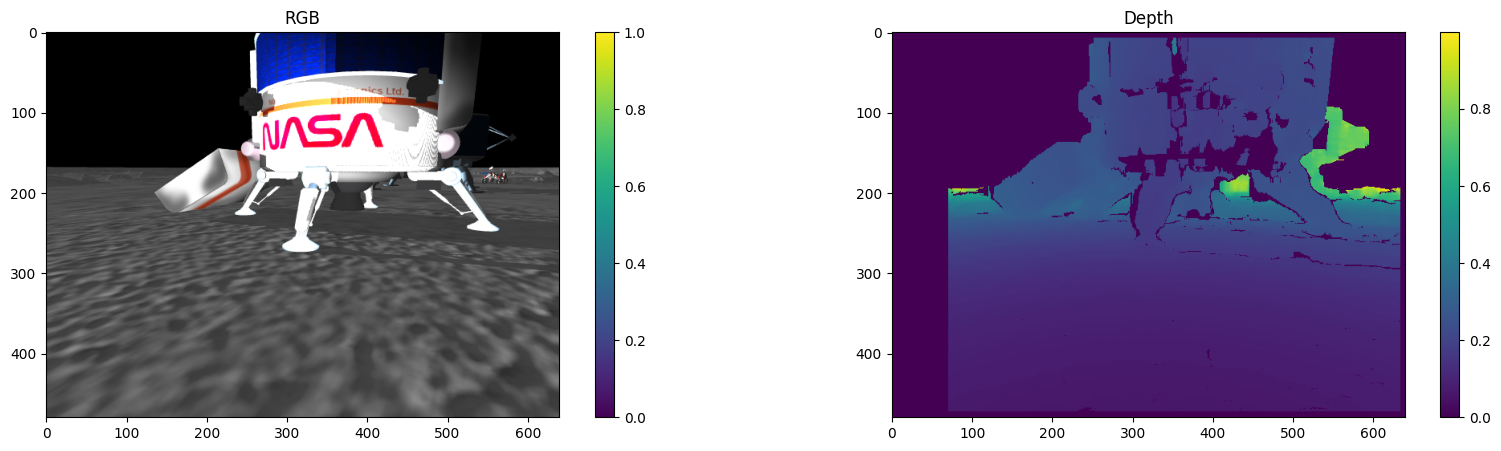

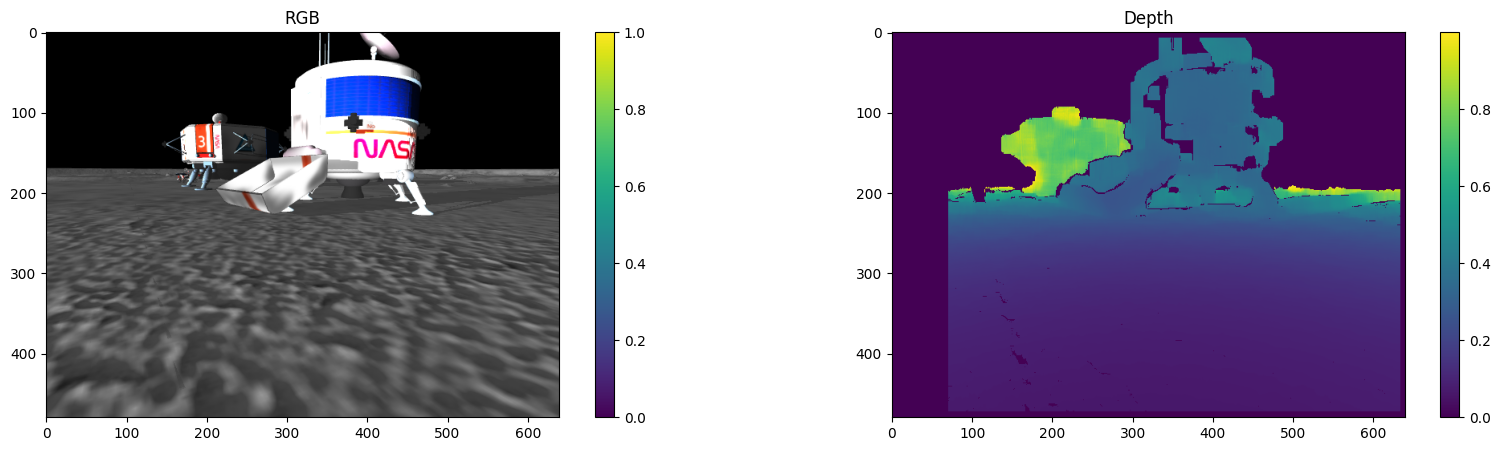

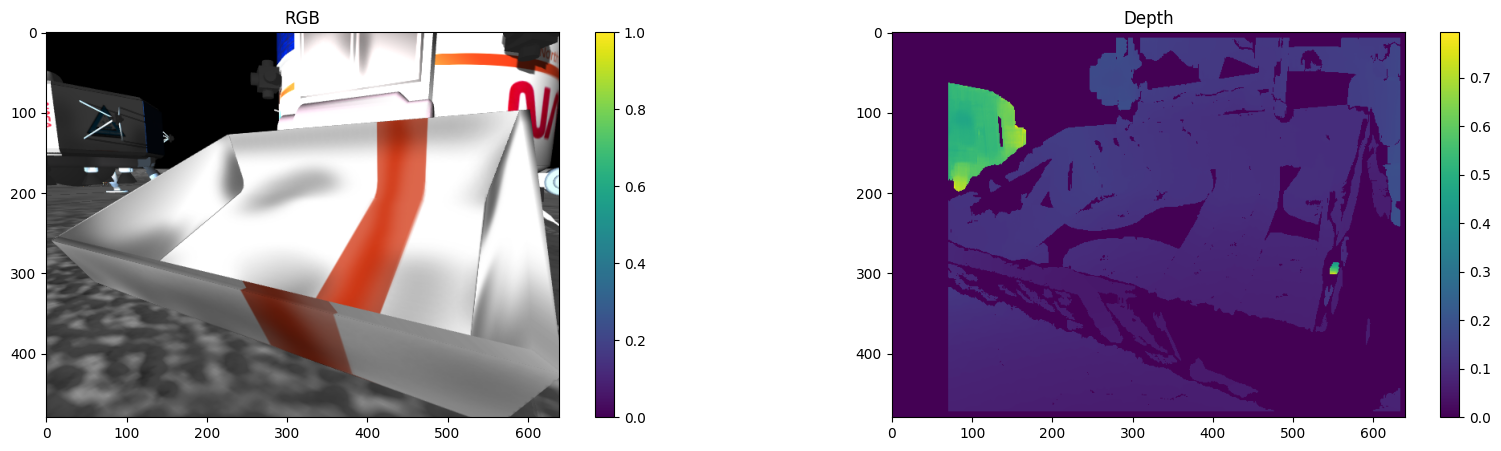

In [ ]:
for image, label in ds.skip(6).take(3):
    pose_utils.show_rgbd(image, format='rgbd')
    d, theta, yaw = label.numpy()
    print(f"raw:   d = {d:.3f} , theta = {theta:.3f}    , yaw = {yaw:.3f} ")
    print(f"human: d = {d / METERS_TO_SCALED:.2f} m, theta = {theta / RAD_TO_SCALED / DEG_TO_RAD:.1f} deg, yaw = {yaw / RAD_TO_SCALED / DEG_TO_RAD:.1f} deg")

In [ ]:
# load entire dataset *labels* into memory (discard images)
labels = np.array([label.numpy() for _, label in ds])
labels.shape

(195, 3)

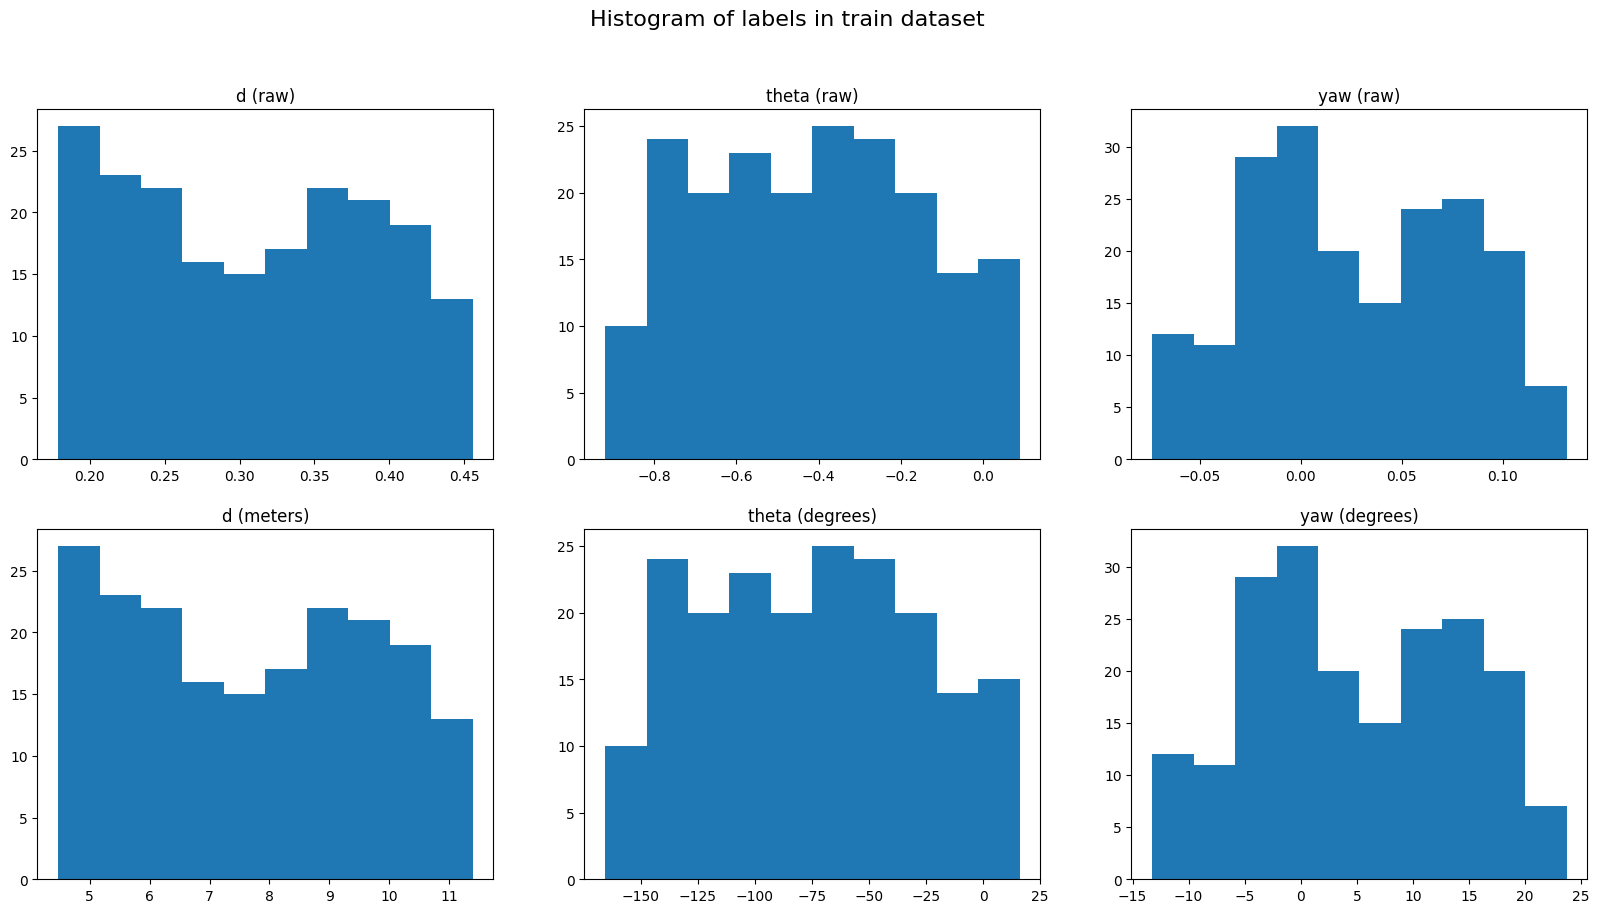

In [ ]:
pose_utils.hist_labels(
    labels,
    title=f'Histogram of labels in {ds_split} dataset'
);

In [ ]:
pose_utils.subplot_labels(
    labels,
    viz='raw',
    title='plot of labels for entire dataset',
    subset=None
)

In [ ]:
pose_utils.subplot_labels(
    labels,
    viz='human',
    # title='subset of labels scaled to human readable units',
    subset=None
)

More intuitive: make a top view map of the poses in the dataset

Each blue dot is one sample :

- position_x = distance * cos(theta)
- position_y = distance * sin(theta)

Each blue dot has a black arrow, indicating the pointing direction of the camera on the rover

absolute yaw = yaw + theta + pi/2

real_yaw = orientamento robot w.r.t world

theta = deve avere offset di 90 gradi

absolute yaw = gradi di rotazione del robot per raggiungere l'oggetto

In [ ]:
!pip install mplcursors


## Plot the polar cordintaes and yaw

In [ ]:
def plot_rover_with_angle(r_list, theta_list, yaw_list, angle_deg=5.8, title="Rover Polar Plot"):
    r_list = np.array(r_list)
    theta_list = np.array(theta_list)
    if yaw_list is not None:
        yaw_list = np.array(yaw_list)
    else:
        yaw_list = np.zeros_like(r_list)

    # Coordinate cartesiane dei punti rover
    x_list = r_list * np.cos(theta_list)
    y_list = r_list * np.sin(theta_list)

    # Crea la figura
    fig = go.Figure()

    # Aggiungi i punti rover
    fig.add_trace(go.Scatter(
        x=x_list,
        y=y_list,
        mode='markers',
        marker=dict(color='blue', size=12),
        hovertemplate=
            "r = %{customdata[0]:.2f}<br>" +
            "θ = %{customdata[1]:.1f}°<br>" +
            "yaw = %{customdata[2]:.1f}°<extra></extra>",
        customdata=np.stack([r_list, np.degrees(theta_list), np.degrees(yaw_list)], axis=-1),
        name="Rover points"
    ))

    # Aggiungi linee rosse dal centro ai punti
    for x, y in zip(x_list, y_list):
        fig.add_trace(go.Scatter(
            x=[0, x],
            y=[0, y],
            mode='lines',
            line=dict(color='red', dash='dash', width=1),
            showlegend=False
        ))

    # Aggiungi linee nere corte per indicare l'orientamento (yaw)
    line_length = 0.3  # lunghezza della linea nera (in metri circa)
    for x, y, yaw, theta in zip(x_list, y_list, yaw_list, theta_list):
        absolute_yaw = yaw + theta + np.pi / 2

        x_end = x + line_length * np.cos(absolute_yaw)
        y_end = y + line_length * np.sin(absolute_yaw)
        fig.add_trace(go.Scatter(
            x=[x, x_end],
            y=[y, y_end],
            mode='lines',
            line=dict(color='black', width=2),
            showlegend=False
        ))

    # Aggiungi linea di riferimento a angle_deg
    angle_rad = np.radians(angle_deg)
    r_max = np.max(r_list)*1.2  # lunghezza linea fino a coprire il grafico
    x_end = r_max * np.cos(angle_rad)
    y_end = r_max * np.sin(angle_rad)

    fig.add_trace(go.Scatter(
        x=[0, x_end],
        y=[0, y_end],
        mode='lines',
        line=dict(color='green', width=2),
        name=f"{angle_deg}°"
    ))

    # Layout grafico
    fig.update_layout(
        title=title,
        width=1000,
        height=1000,
        xaxis=dict(scaleanchor="y", scaleratio=1),
        yaxis=dict(scaleanchor="x", scaleratio=1),
        template="plotly_white"
    )

    fig.show()


In [ ]:
d_true = labels[1:20, 0] / METERS_TO_SCALED
theta_true = labels[1:20, 1] / RAD_TO_SCALED
yaw_true = labels[1:20, 2] / RAD_TO_SCALED
print(len(d_true))
print(len(theta_true))
print(len(yaw_true))

plot_rover_with_angle(d_true, theta_true, yaw_true)

19
19
19


In [ ]:
def plot_optical_poses1(
    d_optical, theta_optical, yaw_optical,
    title='training',
    subset=None,
    footprint='processing_plant'
):
    x_list = [r * np.cos(theta) for r, theta in zip(d_optical, theta_optical)]
    y_list = [r * np.sin(theta) for r, theta in zip(d_optical, theta_optical)]
    yaw_list = yaw_optical; #[yaw + theta + np.pi / 2. for yaw, theta in zip(yaw_optical, theta_optical)]

    fig = pose_utils.viz_positions(x_list, y_list, yaw_list, name=title, subset=subset, footprint=footprint)
    fig, annotations = pose_utils.viz_orientations(fig, x_list, y_list,yaw_list)# [y + np.pi / 2. for y in yaw_list], subset=subset)  # add pi/2 for vizualization to make the arrow point to the front of the rover
    fig.update_layout(title=title)
    return fig

In [ ]:
# Show theta
d_true = labels[:, 0] / METERS_TO_SCALED
theta_true = labels[:, 1] / RAD_TO_SCALED
yaw_true = labels[:, 2] / RAD_TO_SCALED

plot_optical_poses1(
    d_true, theta_true, theta_true,
    title=f"theta true in {ds_split} dataset",
    subset=None,
    footprint=target
)

In [ ]:
# Show theta + pi/2
d_true = labels[:, 0] / METERS_TO_SCALED
theta_true = labels[:, 1] / RAD_TO_SCALED
yaw_true = labels[:, 2] / RAD_TO_SCALED

plot_optical_poses1(
    d_true, theta_true, d_true,
    title=f"top view of theta real + pi/2 {ds_split} dataset",
    subset=None,
    footprint=target
)

In [ ]:
# show yaw ->
d_true = labels[:, 0] / METERS_TO_SCALED
theta_true = labels[:, 1] / RAD_TO_SCALED
yaw_true = labels[:, 2] / RAD_TO_SCALED

plot_optical_poses1(
    d_true, theta_true, yaw_true,
    title=f"top view of yaw true in {ds_split} dataset",
    subset=None,
    footprint=target
)

In [ ]:
# show yaw absolute = yaw + (theta + pi/2) -> rotazione per arrivare al goal
d_true = labels[:, 0] / METERS_TO_SCALED
theta_true = labels[:, 1] / RAD_TO_SCALED
yaw_true = labels[:, 2] / RAD_TO_SCALED

# pose_utils
# ds_train = ml_utils.load_dataset(tf_data_path + '_train', compression='GZIP')

# ds_val = ml_utils.load_dataset(tf_data_path + '_val', compression='GZIP')

# ds_test = ml_utils.load_dataset(tf_data_path + '_test', compression='GZIP').plot_optical_poses(
#     d_true, theta_true, yaw_true,
#     title=f"top view of absolute yaw in {ds_split} dataset",
#     subset=None,
#     footprint=target
# )




Notes:

1. the origin of all poses always coincides with the origin of the target object (e.g the processing plant, another rover)
2. there is sometimes a lack of poses near the edges of a dataset (e.g top right of the processing plant): this bias is due to uneven ground in this region that violated the criteria for the rover's pitch and roll to be within +/- 5 degrees to capture a dataset sample
3. the uniform distribution of distance and theta has the effect of creating:
- a more dense sampling of poses near the origin
- a more sparse sampling of poses far from the origin
This should give higher accuracy for poses closer to the origin, which is a desirable trait

# Neural Network

In [ ]:
'''
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Nessuna GPU trovata.")
'''

'\nphysical_devices = tf.config.list_physical_devices(\'GPU\')\nif physical_devices:\n    tf.config.experimental.set_memory_growth(physical_devices[0], True)\nelse:\n    print("Nessuna GPU trovata.")\n'

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
ds_train = ml_utils.load_dataset(tf_data_path + '_train', compression='GZIP')
ds_train = ds_train.shard(num_shards=15, index=0)

ds_val = ml_utils.load_dataset(tf_data_path + '_val', compression='GZIP')
ds_val = ds_val.shard(num_shards=15, index=0)

ds_test = ml_utils.load_dataset(tf_data_path + '_test', compression='GZIP')
ds_test = ds_test.shard(num_shards=15, index=0)

In [ ]:
from tensorflow.keras import layers


Define the CNN model:


In [ ]:
def build_model(input_shape, height, width, pool_size=(2, 2), n_outputs=1):
    """
    Costruisce e restituisce un modello CNN (Convolutional Neural Network) con Keras.

    Argomenti:
      input_shape: tupla, es. (orig_h, orig_w, channels) — forma delle immagini in ingresso.
      height, width: int — dimensioni target a cui ridimensionare le immagini.
      pool_size: tupla o int — finestra per il MaxPooling2D (default (2,2)).
      n_outputs: int — numero di valori in uscita (es. 1 per regressione o numero di classi).

    Ritorna:
      Un modello Keras Sequential
    """
    model = keras.Sequential(
        [
            # Definisce la forma di input attesa (senza la dimensione batch).
            keras.Input(shape=input_shape),  # -> (orig_h, orig_w, channels)

            # Ridimensiona le immagini a una dimensione fissa (height, width).
            # Dopo questa operazione: (height, width, channels)
            layers.Resizing(height, width),

            # --- Primo blocco convoluzionale ---
            # Convoluzione 2D con 32 filtri 3x3. padding='same' mantiene le dimensioni spaziali.
            # Attivazione ReLU introduce non linearità.
            # Output dopo ogni Conv2D: (height, width, 32)
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"), # 2D perché sono grey scale images???
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),

            # MaxPooling riduce le dimensioni spaziali con un fattore definito da pool_size.
            # Esempio: pool_size=(2,2) dimezza height e width.
            # Output: (height/2, width/2, 32)
            layers.MaxPooling2D(pool_size=pool_size),

            # --- Secondo blocco convoluzionale ---
            # Aumenta i filtri a 64 per imparare caratteristiche più complesse.
            # Due conv + pooling.
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=pool_size),

            # --- Terzo blocco ---
            # 128 filtri per catturare caratteristiche di livello superiore.
            # Dopo conv, ancora pooling per ridurre le dimensioni.
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=pool_size),

            # --- Quarto blocco ---
            # Ancora una conv da 128 filtri + pooling.
            layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D(pool_size=pool_size),

            # Flatten trasforma le feature map 3D (H x W x C) in un vettore 1D.
            # Serve per passare alle Dense.
            layers.Flatten(),  # -> vettore lungo (H_final * W_final * 128)

            # --- Testa fully connected ---
            # Dense = livelli completamente connessi per combinare le feature.
            # ReLU mantiene non-linearità.
            layers.Dense(6, activation="relu"),   # piccolo "collo di bottiglia"
            layers.Dense(24, activation="relu"),  # espansione della rappresentazione
            layers.Dense(24, activation="relu"),  # altra trasformazione

            # Dropout spegne casualmente il 10% dei neuroni in training (regularizzazione).
            layers.Dropout(0.1),

            # Ultimo livello Dense.
            # activation="linear" = output continuo (utile per regressione).
            # Per classificazione si userebbe "softmax" o "sigmoid".
            layers.Dense(n_outputs, activation="linear"),
        ]
    )

    return model


# Initialize the model

In [ ]:
model = build_model(
    (480, 640, 4),
    120, 160,
    n_outputs=3,
    pool_size=2
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 120, 160, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 120, 160, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 20, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        53,766 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 341,905 (1.30 MB)

 Trainable params: 341,905 (1.30 MB)

 Non-trainable params: 0 (0.00 B)

## Define the loss function and hyperparameters

Spiegare perchè abbiamo messo questi èarametri nelle riga,
spiegare nuemro di epoche, alpha e beta che definiscono il valore da dare alla loss.

In [ ]:
alpha = 1/3 #0.1
beta = 1/6 #0.03
gamma = 1/2
batch_size = 32

ds_train_b = ds_train.batch(batch_size, drop_remainder=True)
ds_val_b = ds_val.batch(batch_size, drop_remainder=True)
ds_test_b = ds_test.batch(batch_size, drop_remainder=True)

def pose_loss(y_true, y_pred):
    pose_loss = \
        gamma * ml_utils.distance_loss(y_true, y_pred) +  \
        alpha * ml_utils.theta_loss(y_true, y_pred) + \
        beta * ml_utils.orientation_loss(y_true, y_pred)
    return pose_loss

def theta_loss(y_true, y_pred):
    return alpha * ml_utils.theta_loss(y_true, y_pred)

def orientation_loss(y_true, y_pred):
    return beta * ml_utils.orientation_loss(y_true, y_pred)

model.compile( # preparere il modello per il fit, prende le loss function e l'ottimizzatore
    loss=pose_loss,
    optimizer='adam',
    metrics=[
        ml_utils.distance_loss,     # intermediate loss, for tuning alpha and beta
        theta_loss,                 # intermediate loss, for tuning alpha and beta
        orientation_loss,           # intermediate loss, for tuning alpha and beta
        ml_utils.distance_diff,     # intermediate errors: human understandable
        ml_utils.theta_diff,        # intermediate errors: human understandable
        ml_utils.orientation_diff,  # intermediate errors: human understandable
    ]
)

## Train the model

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=4,
        verbose=1,
        restore_best_weights=True
    )
]

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'  # garantisce compatibilità con Colab

def plot_training_history(history):
    """
    Plotta tutte le metriche e loss presenti in history in un grafico interattivo.
    """
    fig = go.Figure()

    for key in history.history.keys():
        fig.add_trace(go.Scatter(
            y=history.history[key],
            mode='lines+markers',
            name=key
        ))

    fig.update_layout(
        title='Training Progress',
        xaxis_title='Epoch',
        yaxis_title='Value',
        legend_title='Metric',
        template='plotly_dark'  # opzionale: tema scuro
    )
    fig.show()




# Numero di epoche
Bisogna fare un analisi e capire perchè abbiamo utilizzato questo specifico numero di epoche. Trovare relazione tra numero di epoche e overfit o fit del modello.

In [ ]:
''' history = model.fit(
    ds_train_b,
    epochs=100,
    validation_data=ds_val_b,
    callbacks=callbacks,
)

# Plot the results
plot_training_history(history)
'''
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output

class MetricsPlotter(Callback):
    def on_train_begin(self, logs=None):
        self.train_losses = []
        self.val_losses = []
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        # Salvo metriche di questa epoca
        self.train_losses.append(logs["loss"])
        self.val_losses.append(logs["val_loss"])
        self.train_acc.append(logs.get("accuracy"))
        self.val_acc.append(logs.get("val_accuracy"))

        # Pulisco output e disegno grafici
        clear_output(wait=True)
        fig, axs = plt.subplots(1, 2, figsize=(14,5))

        # Grafico loss
        axs[0].plot(self.train_losses, label="Training loss")
        axs[0].plot(self.val_losses, label="Validation loss")
        axs[0].set_xlabel("Epoche")
        axs[0].set_ylabel("Loss")
        axs[0].set_title("Andamento della Loss")
        axs[0].legend()
        axs[0].grid(True)

        # Grafico accuracy
        axs[1].plot(self.train_acc, label="Training accuracy")
        axs[1].plot(self.val_acc, label="Validation accuracy")
        axs[1].set_xlabel("Epoche")
        axs[1].set_ylabel("Accuracy")
        axs[1].set_title("Andamento della Accuracy")
        axs[1].legend()
        axs[1].grid(True)

        plt.show()

# # Usa solo il callback grafico
# callbacks = [MetricsPlotter()]

history = model.fit(
    ds_train_b,
    epochs=100,
    validation_data=ds_val_b,
    # callbacks=callbacks,
)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 83s 12s/step - distance_diff: 7.4025 - distance_loss: 0.0943 - loss: 0.1276 - orientation_diff: 7.9826 - orientation_loss: 4.9440e-04 - theta_diff: 75.7005 - theta_loss: 0.0799 - val_distance_diff: 7.1212 - val_distance_loss: 0.0857 - val_loss: 0.1215 - val_orientation_diff: 9.3138 - val_orientation_loss: 5.7178e-04 - val_theta_diff: 74.2044 - val_theta_loss: 0.0781
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 69s 12s/step - distance_diff: 7.0458 - distance_loss: 0.0858 - loss: 0.1168 - orientation_diff: 7.9667 - orientation_loss: 4.5280e-04 - theta_diff: 71.9959 - theta_loss: 0.0734 - val_distance_diff: 6.4973 - val_distance_loss: 0.0721 - val_loss: 0.1123 - val_orientation_diff: 9.8251 - val_orientation_loss: 6.1984e-04 - val_theta_diff: 72.6564 - val_theta_loss: 0.0756
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 68s 12s/step - distance_diff: 6.4173 - distance_loss: 0.0725 - loss: 0.1075 - orientation_diff: 7.9826 - orientation_loss: 4.3058e-04 - theta_diff: 70.

## Evaluate the model

In [ ]:
min_loss, min_loss_epoch, min_pdiff, min_pdiff_epoch = \
    ml_utils.get_best_metrics(
        history,
        accuracy_metric='distance_diff'
)
print(f"min_loss  = {min_loss:.5f} @ epoch {min_loss_epoch}")
print(f"min_pdiff = {min_pdiff:.3f}   @ epoch {min_pdiff_epoch}")

In [ ]:

results = model.evaluate(ds_test_b)
print(f"avg_position_diff = {results[-3]:.3f} meters")
print(f"avg_theta_diff = {results[-2]:.1f} degrees")
print(f"avg_orientation_diff = {results[-1]:.1f} degrees")
ds_test_b = ds_test.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)


results = model.evaluate(ds_test_b)
print(f"avg_position_diff = {results[-3]:.3f} meters")
print(f"avg_theta_diff = {results[-2]:.1f} degrees")
print(f"avg_orientation_diff = {results[-1]:.1f} degrees")


In [ ]:
n_pred = 100
d_true, theta_true, yaw_true, d_list, theta_list, yaw_list = \
    ml_utils.predict_and_scale(
        model,
        ds_test,
        ds_test_b,
        n_pred,
        batch_size
)

In [ ]:
pose_utils.compare_each_output(
    d_true, theta_true, yaw_true,
    d_list, theta_list, yaw_list,
    subset=50
)

In [ ]:
pose_utils.compare_optical_poses(
    d_true, theta_true, yaw_true,
    d_list, theta_list, yaw_list,
    yaw_viz_offset=np.pi/2.,
    footprint=target
)

In [ ]:
pose_utils.hist_errors(
    d_true, theta_true, yaw_true,
    d_list, theta_list, yaw_list
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_loss = history.history['loss']
val_loss   = history.history['val_loss']

# Trova l'epoca della minima validation loss
min_val_epoch = np.argmin(val_loss)
min_val_value = val_loss[min_val_epoch]
print(f"Minimum value of loss on validation set  = {min_loss:.5f} at epoch {min_loss_epoch}")

plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

# Linea verticale sul minimo della val_loss
plt.axvline(x=min_val_epoch, color='red', linestyle='--', label=f'Val Loss Min Epoch {min_val_epoch}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import matplotlib.pyplot as plt

for key in history.history.keys():
    if not key.startswith('val_'):
        plt.figure(figsize=(8,5))
        plt.plot(history.history[key], label=f'Train {key}')
        plt.plot(history.history[f'val_{key}'], label=f'Val {key}')
        plt.xlabel('Epochs')
        plt.ylabel(key)
        plt.title(f'{key} over epochs')
        plt.legend()
        plt.grid(True)
        plt.show()
